<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/097.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pygeohash
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install optuna

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [4]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train.csv', index_col=0)

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test.csv', index_col=0)

In [5]:
train_df

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,...,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,5.297314e+04
1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,5.822520e+04,76376.547318,5.591007e+04
2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.567954e+04
3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,...,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,6.364734e+04,53799.011225,6.141190e+04
4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,...,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,7.739116e+04,17662.966241,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,MIDLOTHIAN COMPRESSOR STATION,32.523334,-97.102556,2624 CHAMBERS ST.,VENUS,TX,76084,JOHNSON,48251.0,211111,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,54978.841280,56463.765036,3.522786e+06,76642.640670,2.451197e+06
4651,PARADISE COMPRESSOR STATION,42.684900,-109.780000,"SECTION 2, T31N, R109W",PINEDALE,WY,82941,SUBLETTE,56035.0,211111,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,208375.435367,57066.624445,4.858030e+04,26892.366779,3.573974e+04
4652,UNIV OF OK HEALTH S/OKC CAMPUS SVCS,35.484260,-97.498570,800 NE 15TH ST,OKLAHOMA CITY,OK,73104,OKLAHOMA,40109.0,611310,...,Other,NaN,NaN,NaN,NaN,563756.090695,598881.479485,1.665103e+06,543206.073134,9.783592e+05
4653,HARFORD CO. RESOURCE RECOVERY FACILITY,39.404310,-76.319820,1 MAGNOLIA ROAD,JOPPA,MD,21085-4800,HARFORD,24025.0,562213,...,Waste,NaN,NaN,NaN,NaN,67451.225733,27397.929966,3.922795e+04,46634.777768,2.723434e+04


In [6]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['FacilityName', 'Latitude', 'Longitude', 'LocationAddress', 'City',
       'State', 'ZIP', 'County', 'FIPScode', 'PrimaryNAICS',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons'],
      dtype='object')

In [7]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [8]:
# del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df['FacilityName'], test_df['FacilityName']
del train_df['LocationAddress'], test_df['LocationAddress']
del train_df['ZIP'], test_df['ZIP']
del train_df['IndustryType'], test_df['IndustryType']
del train_df['SecondPrimaryNAICS'], test_df['SecondPrimaryNAICS']

In [9]:

two_digit_map     = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [10]:
train_df['first_two_digit_primary_naics'] = train_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)
test_df['first_two_digit_primary_naics']  = test_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)

train_df['Economic_Sector']               = train_df['first_two_digit_primary_naics'].map(two_digit_map)
test_df['Economic_Sector']                = test_df['first_two_digit_primary_naics'].map(two_digit_map)

del train_df['first_two_digit_primary_naics'], test_df['first_two_digit_primary_naics']

econ_sector_train                         = train_df['Economic_Sector'].values
econ_sector_test                          = test_df['Economic_Sector'].values

In [11]:
test_df.shape

(2508, 16)

In [12]:



def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of Earth in kilometers (mean radius)
    R = 6371.0

    # Calculate the distance
    distance = R * c
    return distance

In [13]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat2, lon2)

def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
    # Extract the required columns once to NumPy arrays
    latitudes = train_df['Latitude'].values
    longitudes = train_df['Longitude'].values
    ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
    econ_sectors = train_df['Economic_Sector'].values

    # Filter NaN emissions directly
    valid_indices = ~np.isnan(ghg_emissions)

    latitudes = latitudes[valid_indices]
    longitudes = longitudes[valid_indices]
    ghg_emissions = ghg_emissions[valid_indices]
    econ_sectors = econ_sectors[valid_indices]

    # Parallelize distance calculation using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        distances = list(executor.map(calculate_distance,
                                     [lat1]*len(latitudes),
                                     [lon1]*len(longitudes),
                                     latitudes,
                                     longitudes))

    # Combine the results into a DataFrame
    near_df = pd.DataFrame({
        'Distance': distances,
        'GHG_emission_14': ghg_emissions,
        'Economic_Sector': econ_sectors
    })


    if train_point:
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()
        near_df = near_df.iloc[1:].reset_index(drop=True)
    else:
        # Sort distances by 'Distance'
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()

    # Filter by economic sector
    nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

    # Get the top N nearest for both economic sector and overall
    sub_near_econ = nearest_locations_econ_sector.head(neighbours)
    sub_nearest_locations = near_df.head(neighbours)

    # Compute weighted averages
    econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
    near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

    # Compute regular averages
    econ_average = sub_near_econ['GHG_emission_14'].mean()
    near_average = sub_nearest_locations['GHG_emission_14'].mean()

    return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [14]:
# neighbours = 5

# # テストデータの距離計算または読み込み
# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     test_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):
#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=False)
#         output.append(x)

#     test_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     test_distance.to_csv(file_path, index=False)

# # トレーニングデータの距離計算または読み込み
# file_path = f"train_distance_{neighbours}nbrs.csv"  # f-string を正しく使用
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     train_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=True)
#         output.append(x)

#     train_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     train_distance.to_csv(file_path, index=False)

train_distance = pd.read_csv(path+"train_distance_5nbrs.csv")
test_distance  = pd.read_csv(path+"test_distance_5nbrs.csv")

In [15]:
test_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Economic_Sector
0,38.033040,-97.973170,HUTCHINSON,KS,RENO,20155.0,211112,NaN,NaN,NaN,NaN,88951.390376,65803.021457,2.899329e+04,32965.487915,"Mining, Quarrying, and Oil and Gas Extraction"
1,32.316030,-108.606800,LORDSBURG,NM,HIDALGO,35023.0,486210,NaN,NaN,NaN,NaN,NaN,NaN,3.119260e+05,268668.069110,Transportation and Warehousing
2,41.251500,-78.742440,BROCKPORT,PA,JEFFERSON,42065.0,327213,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,3.473291e+04,39045.247387,Manufacturing
3,44.959660,-93.193410,SAINT PAUL,MN,RAMSEY,27123.0,322130,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,1.426237e+04,20204.924986,Manufacturing
4,32.818720,-117.125800,SAN DIEGO,CA,SAN DIEGO,6073.0,333611,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,4.000654e+04,63935.249120,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,38.651945,-75.914445,HURLOCK,MD,DORCHESTER,24019.0,562212,NaN,NaN,NaN,NaN,110523.066755,98954.793233,3.467008e+06,147802.356027,Administrative and Support and Waste Managemen...
2504,31.361795,-101.776403,RANKIN,TX,UPTON,48461.0,211112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mining, Quarrying, and Oil and Gas Extraction"
2505,41.005565,-96.154917,LOUISVILLE,NE,CASS,31025.0,327310,22956.125554,23592.402994,25069.498286,24560.172725,166520.232511,469732.826538,8.255855e+04,85775.307153,Manufacturing
2506,39.364417,-93.449361,CARROLLTON,MO,CARROLL,29033.0,325193,124460.895022,140816.449347,93118.705227,130326.946431,71773.803649,936031.894142,3.369613e+05,156640.371706,Manufacturing


In [16]:
test_distance

,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average
0,28019.568906,369614.866259,454847.563793,606222.120889
1,1296.575343,75372.922188,26392.933789,299096.231937
2,59857.420688,44340.597367,81533.914173,203831.976280
3,45265.635701,127292.222361,297072.418525,405635.394345
4,8838.742950,70847.235694,617665.034364,290001.288780
...,...,...,...,...
2503,46677.018970,344616.752313,45282.942220,309317.094507
2504,290186.877822,544751.143291,290186.877822,544751.143291
2505,102525.917615,658668.333532,100759.314574,598531.117832
2506,3259.275220,58047.779667,8262.408868,91773.030660


In [17]:
train_df.shape

(4655, 17)

In [18]:
train_df = pd.concat([train_df, train_distance], axis=1)
test_df = pd.concat([test_df, test_distance], axis=1)


In [19]:
def create_features1(df):


    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

   # Year-over-year growth rate with NaN protection
    df['TRI_Air_Emissions_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                 'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

In [20]:
def create_features2(df):


    # Year-over-year difference
    df['GHG_Direct_Emissions_YoY_Change_11'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']

    # Year-over-year growth rate for GHG Direct Emissions with NaN protection
    df['GHG_Direct_Emissions_Growth_Rate_11'] = np.where(
        df['GHG_Direct_Emissions_10_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_10_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_12'] = np.where(
        df['GHG_Direct_Emissions_11_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_11_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_13'] = np.where(
        df['GHG_Direct_Emissions_12_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_12_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']) / df['GHG_Direct_Emissions_12_in_metric_tons'],
        np.nan
    )

    return df


new_features2 = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                 'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                 ]
train_df      = create_features2(train_df)
test_df       = create_features2(test_df)

In [21]:
def create_features3(df):
    df['TRI_to_GHG_Ratio_10'] = np.where(df['GHG_Direct_Emissions_10_in_metric_tons'].notna(),
                                     df['TRI_Air_Emissions_10_in_lbs'] / df['GHG_Direct_Emissions_10_in_metric_tons'],
                                     np.nan)

    df['TRI_to_GHG_Ratio_11'] = np.where(df['GHG_Direct_Emissions_11_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_11_in_lbs'] / df['GHG_Direct_Emissions_11_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_12'] = np.where(df['GHG_Direct_Emissions_12_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_12_in_lbs'] / df['GHG_Direct_Emissions_12_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_13'] = np.where(df['GHG_Direct_Emissions_13_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_13_in_lbs'] / df['GHG_Direct_Emissions_13_in_metric_tons'],
                                        np.nan)
    return df



train_df      = create_features3(train_df)
test_df       = create_features3(test_df)
new_features3 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

In [22]:
summary_df = train_df.groupby(['Economic_Sector', 'State']).agg({'GHG_Direct_Emissions_14_in_metric_tons': ['mean', 'median', 'max', 'min','count']})

summary_df.columns = [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]

summary_df = summary_df.reset_index()

train_df = train_df.merge(summary_df, on=['Economic_Sector', 'State'], how='left')
test_df  = test_df.merge(summary_df,  on=['Economic_Sector', 'State'], how='left')

In [23]:
test_df.shape

(2508, 41)

In [24]:
train_df.shape

(4655, 42)

In [25]:
merged_df = pd.concat((train_df,test_df),axis=0)
for cols in ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']:
    le              = LabelEncoder()
    merged_df[cols] = le.fit_transform(merged_df[cols].values.reshape(-1,1))

train_df = merged_df.iloc[:train_df.shape[0],:]
test_df  = merged_df.iloc[train_df.shape[0]:,:]
train_df.shape,test_df.shape

((4655, 42), (2508, 42))

In [26]:
train_df["num_missing"] = train_df.iloc[:, 5:9].isna().any(axis=1).astype(int)
test_df["num_missing"] = test_df.iloc[:, 5:9].isna().any(axis=1).astype(int)
train_df["num_missing"]

,num_missing
0,0
1,1
2,1
3,1
4,0
...,...
4650,1
4651,1
4652,1
4653,1


In [27]:
train_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,Economic_Sector,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,GHG_Direct_Emissions_YoY_Change_11,GHG_Direct_Emissions_YoY_Change_12,GHG_Direct_Emissions_YoY_Change_13,GHG_Direct_Emissions_Growth_Rate_11,GHG_Direct_Emissions_Growth_Rate_12,GHG_Direct_Emissions_Growth_Rate_13,TRI_to_GHG_Ratio_10,TRI_to_GHG_Ratio_11,TRI_to_GHG_Ratio_12,TRI_to_GHG_Ratio_13,GHG_Direct_Emissions_14_in_metric_tons_mean,GHG_Direct_Emissions_14_in_metric_tons_median,GHG_Direct_Emissions_14_in_metric_tons_max,GHG_Direct_Emissions_14_in_metric_tons_min,GHG_Direct_Emissions_14_in_metric_tons_count,num_missing
0,40.141389,-87.581111,760,15,1210,404,118,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,5.297314e+04,8,5398.155496,47189.689731,9791.821519,33589.247020,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,-28228.214295,1.319192e+03,7.690189e+03,-0.435507,0.036055,0.202865,0.487013,0.728229,0.617559,0.697613,224419.585457,58245.531014,3.115016e+06,4809.438832,65.0,0
1,38.475305,-81.278957,596,52,580,1812,221,NaN,NaN,NaN,NaN,55507.543666,72387.334115,5.822520e+04,76376.547318,5.591007e+04,14,162817.726845,400092.854554,148763.385132,132464.910913,NaN,NaN,NaN,NaN,NaN,NaN,16879.790449,-1.416214e+04,1.815135e+04,0.304099,-0.195644,0.311744,NaN,NaN,NaN,NaN,237021.486262,170271.119319,6.625098e+05,38397.312643,10.0,1
2,39.299820,-80.857170,1267,52,971,1831,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.567954e+04,9,103977.856885,417284.756655,218812.028673,483238.414520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142552.424055,63548.856747,1.509645e+06,10597.019460,44.0,1
3,35.490363,-119.042957,158,4,597,118,21,NaN,NaN,NaN,NaN,54811.222708,69339.923002,6.364734e+04,53799.011225,6.141190e+04,15,131970.843732,103867.454791,131970.843732,103867.454791,NaN,NaN,NaN,NaN,NaN,NaN,14528.700293,-5.692583e+03,-9.848329e+03,0.265068,-0.082097,-0.154733,NaN,NaN,NaN,NaN,247798.633304,67577.976327,2.486906e+06,4179.320811,98.0,1
4,41.532802,-81.636448,598,36,289,1206,21,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,7.739116e+04,17662.966241,4.310047e+04,15,13380.967037,32692.160052,59477.156966,94820.654861,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,-27988.744776,2.356760e+04,-5.972819e+04,-0.342109,0.437868,-0.771770,0.361239,0.526495,0.398506,1.424104,180512.811869,45651.313438,2.126404e+06,12939.347198,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,32.523334,-97.102556,3123,45,570,1588,3,NaN,NaN,NaN,NaN,54978.841280,56463.765036,3.522786e+06,76642.640670,2.451197e+06,9,180502.129556,330574.656900,116105.385412,145931.879241,NaN,NaN,NaN,NaN,NaN,NaN,1484.923756,3.466322e+06,-3.446143e+06,0.027009,61.390201,-0.978244,NaN,NaN,NaN,NaN,292116.442605,66394.923918,3.422654e+06,3292.319102,184.0,1
4651,42.684900,-109.780000,2382,53,1135,1898,3,NaN,NaN,NaN,NaN,208375.435367,57066.624445,4.858030e+04,26892.366779,3.573974e+04,9,54997.983919,348657.682514,54997.983919,348657.682514,NaN,NaN,NaN,NaN,NaN,NaN,-151308.810922,-8.486325e+03,-2.168793e+04,-0.726136,-0.148709,-0.446435,NaN,NaN,NaN,NaN,297602.086194,67780.169542,2.990948e+06,14635.024868,44.0,1
4652,35.484260,-97.498570,2231,37,842,1301,244,NaN,NaN,Na

In [28]:
numerical_columns = [
                    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                    ]
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']
train_aggregations  =  [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]
new_features1  = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                    'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

new_features2   = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                  'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                  ]
new_features3   = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']
neighbour_feats = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average']


train = train_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                 +["num_missing"]
                 ].values
test  = test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                +["num_missing"]
                 ].values
target = train_df[target_columns].values


In [29]:
test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
        +["num_missing"]
                 ]


,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0


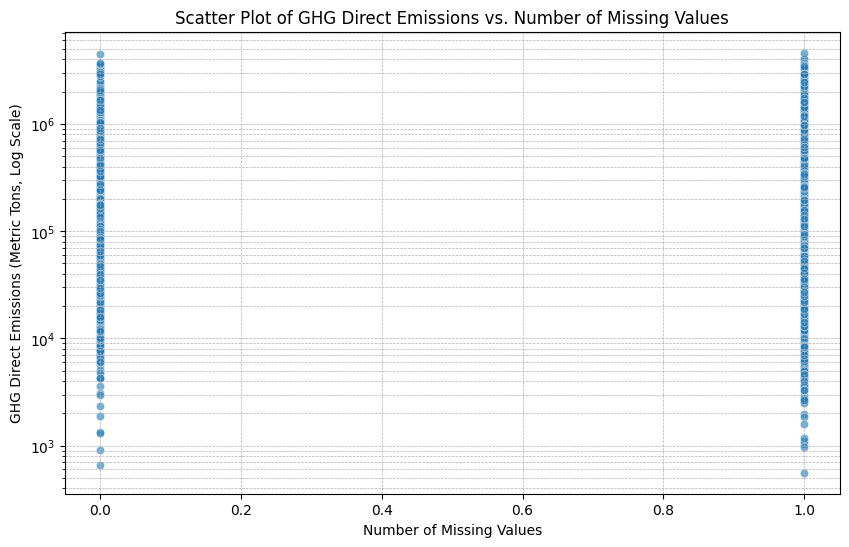

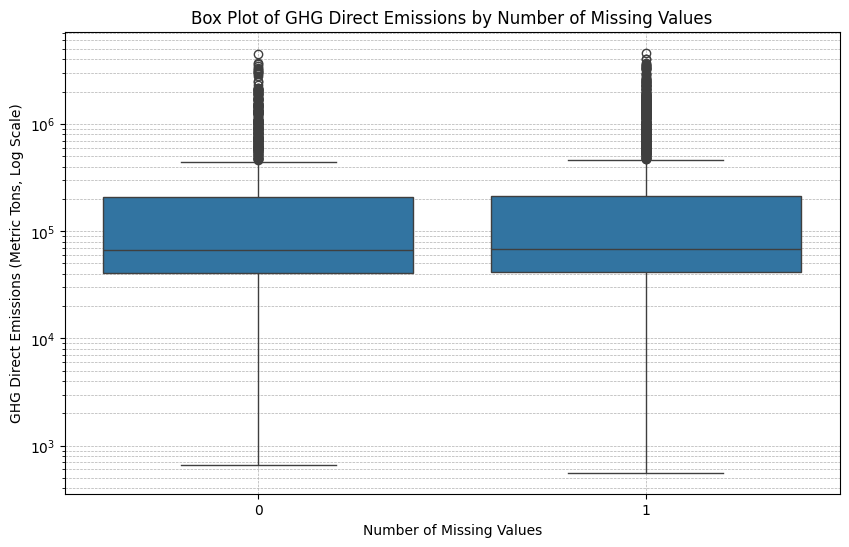

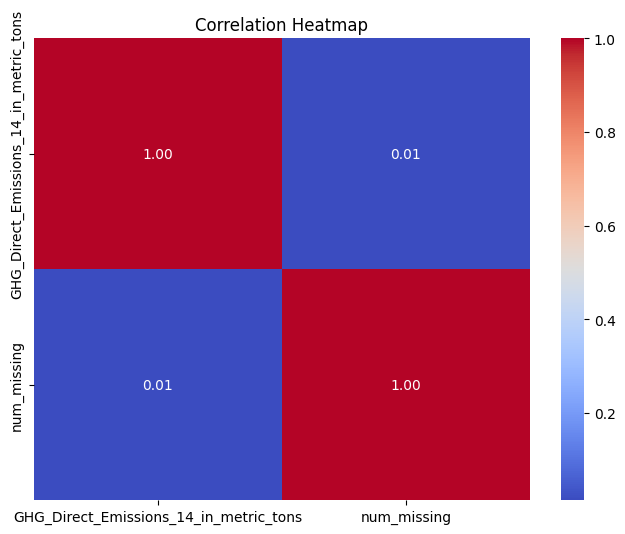

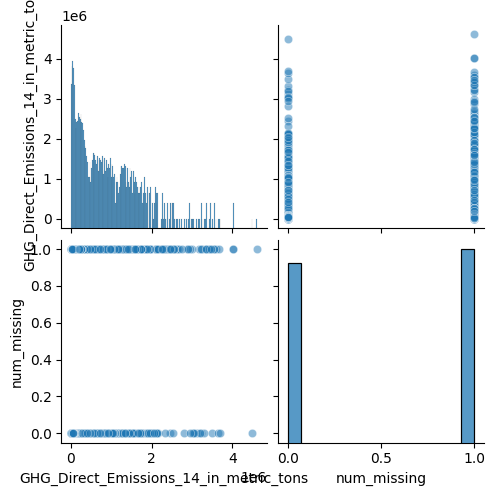

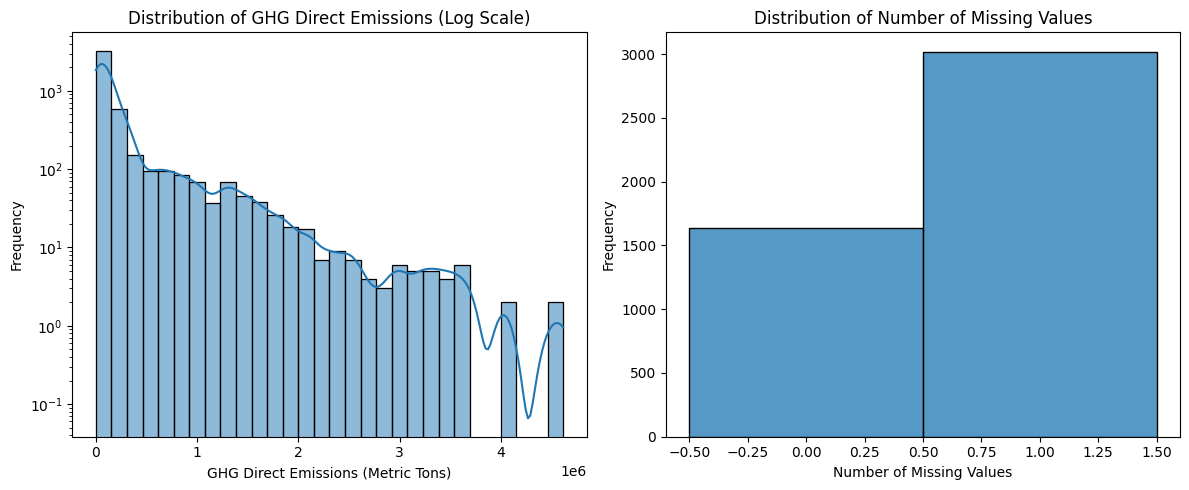

In [30]:

import seaborn as sns
filtered_train_df = train_df[train_df["GHG_Direct_Emissions_14_in_metric_tons"] > 0]
# 1. 散布図（Scatter Plot）
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons",
    alpha=0.6
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Scatter Plot of GHG Direct Emissions vs. Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 2. 箱ひげ図（Box Plot）
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons"
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Box Plot of GHG Direct Emissions by Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 3. ヒートマップ（Heatmap） - 相関行列の可視化
plt.figure(figsize=(8, 6))
correlation = filtered_train_df[["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 4. ペアプロット（Pair Plot） - 複数の視点からの可視化
sns.pairplot(filtered_train_df, vars=["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"],
             kind='scatter', plot_kws={'alpha':0.5})
plt.yscale('log')
plt.show()

# 5. ヒストグラム（Histogram） - 各変数の分布
plt.figure(figsize=(12, 5))

# GHG_Direct_Emissions_14_in_metric_tons のヒストグラム（対数スケール）
plt.subplot(1, 2, 1)
sns.histplot(filtered_train_df["GHG_Direct_Emissions_14_in_metric_tons"], bins=30, kde=True)
plt.yscale('log')
plt.title("Distribution of GHG Direct Emissions (Log Scale)")
plt.xlabel("GHG Direct Emissions (Metric Tons)")
plt.ylabel("Frequency")

# num_missing のヒストグラム
plt.subplot(1, 2, 2)
sns.histplot(filtered_train_df["num_missing"], bins=range(filtered_train_df["num_missing"].max()+2), discrete=True, kde=False)
plt.title("Distribution of Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [31]:
train_df["less_10^4"] = train_df["GHG_Direct_Emissions_14_in_metric_tons"].apply(lambda x: 1 if x < 10**4 else 0)
target_less_10_4 = train_df["less_10^4"].values



In [32]:
cat0 = CatBoostClassifier(
    iterations=864,
    depth=4,
    learning_rate=0.02,
    l2_leaf_reg=1.2322248317139508,
    border_count=254,
    bagging_temperature=0.1
)

cat0.fit(train, target_less_10_4, verbose=0)
oof_preds = cat0.predict_proba(train)
cat0_pred = cat0.predict_proba(test)

In [33]:
sum(cat0_pred[:, 1] > 0.16)

43

In [34]:
target

array([[ 52973.13994629],
       [ 55910.06661677],
       [ 55679.54321391],
       ...,
       [978359.18321926],
       [ 27234.34120387],
       [194822.07077126]])

In [35]:
tmp = 0
ave_less_10_4_log = 0
max(oof_preds[:, 1])
for i in range(len(oof_preds)):
    if oof_preds[i, 1] > 0.16 and target[i] < 10**4:
        ave_less_10_4_log += np.log1p(target[i])
        tmp += 1

ave_less_10_4_log /= tmp
print(ave_less_10_4_log)
ave_less_10_4 = np.expm1(ave_less_10_4_log)[0]
ave_less_10_4

[8.49499017]


4889.20824708803

In [36]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


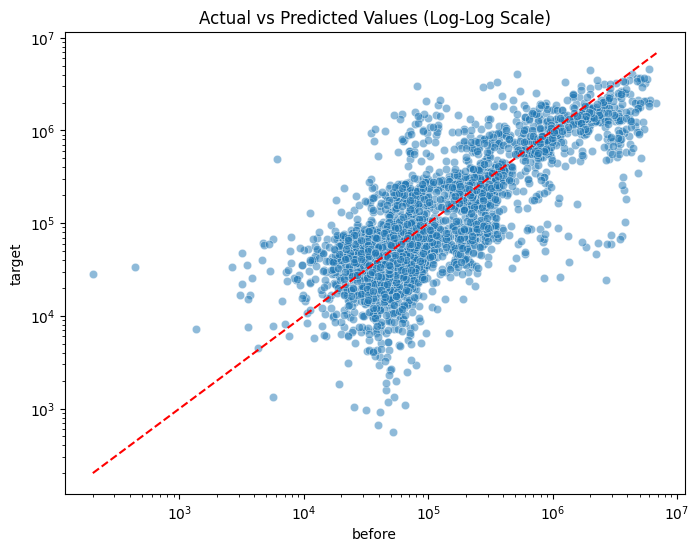

In [37]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

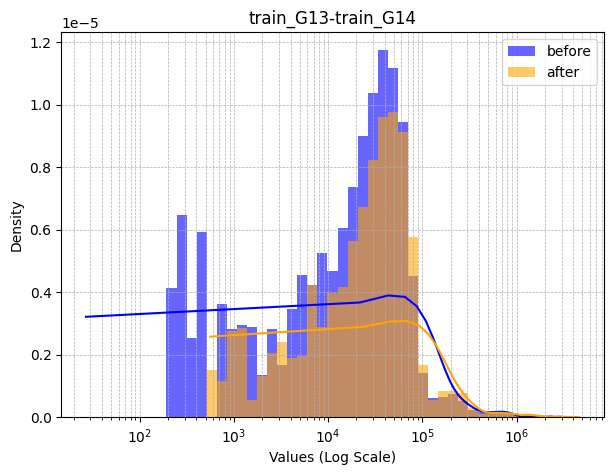

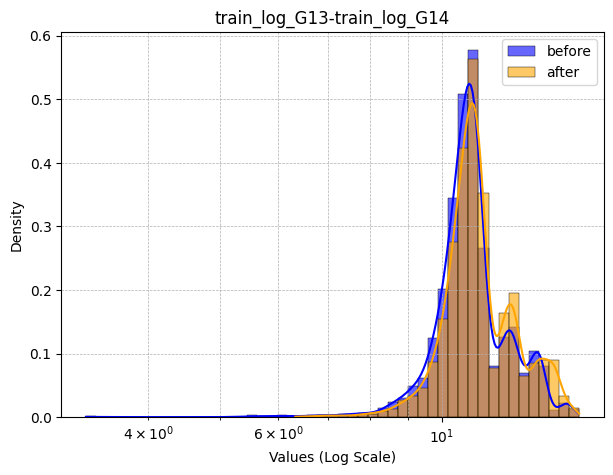

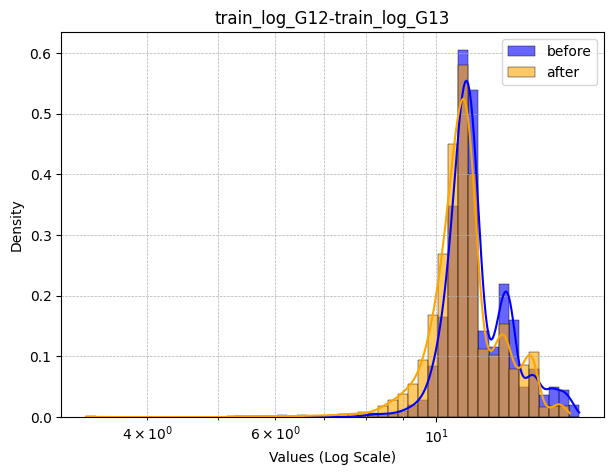

In [38]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [39]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {"n_estimators": 56,"random_state":13,
                                         "verbose":-1,}
        model2                       = LGBMRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, np.log1p(y_train))
            preds = np.expm1(model.predict(X_valid))
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_log_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)

        test_predictions += test_preds / kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_log_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = np.expm1(test_predictions)

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions

In [40]:
oof_predictions,test_preds = get_models_trained(train,test,target,30)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.6748432956893732
Fold 1 RMSLE for model2 = 0.685226641461286
Fold 1 RMSLE for model3 = 0.6726295586656458
Fold 1 RMSLE for model4 = 0.6804740674550488
Fold 1 RMSLE for ('model1', 'model2') = 0.6760323400216317
Fold 1 RMSLE for ('model1', 'model3') = 0.673438823916687
Fold 1 RMSLE for ('model1', 'model4') = 0.6757580527573754
Fold 1 RMSLE for ('model2', 'model3') = 0.67548649028672
Fold 1 RMSLE for ('model2', 'model4') = 0.6782449317968401
Fold 1 RMSLE for ('model3', 'model4') = 0.6747026697803885
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.6741367990936445
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.675478742104954
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.6742335405348721
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.6750077958158676
Fold 1 RMSLE for all models ensemble = 0.6742658172685644
Fold 1 best combination: model3 with RMSLE = 0.6726295586656458
---------------

Starting Fold 2
Fold 2 RMSLE for model1 

In [41]:
train_tmp_df = train_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                 +["num_missing"]+
                  ["GHG_Direct_Emissions_14_in_metric_tons"]
                 ]
test_tmp_df  = test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                +["num_missing"]
                   ]
target = train_df[target_columns]
oof_predictions_pd = pd.DataFrame(oof_predictions, columns=["oof_predictions"])
test_preds_pd = pd.DataFrame(test_preds, columns=["test_preds"])
test_preds_pd = pd.DataFrame(test_preds, columns=["test_preds"])
train_df_1 = pd.concat([train_tmp_df, oof_predictions_pd], axis=1)
train_all_df = pd.concat([train_df_1, target], axis=1)
test_all_df = pd.concat([test_tmp_df, test_preds_pd], axis=1)

In [42]:
test_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,test_preds
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.365953e+04
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,3.184321e+05
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.060332e+04
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.760253e+04
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.707800e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05


In [43]:
train_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,Economic_Sector,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,GHG_Direct_Emissions_YoY_Change_11,GHG_Direct_Emissions_YoY_Change_12,GHG_Direct_Emissions_YoY_Change_13,GHG_Direct_Emissions_Growth_Rate_11,GHG_Direct_Emissions_Growth_Rate_12,GHG_Direct_Emissions_Growth_Rate_13,TRI_to_GHG_Ratio_10,TRI_to_GHG_Ratio_11,TRI_to_GHG_Ratio_12,TRI_to_GHG_Ratio_13,GHG_Direct_Emissions_14_in_metric_tons_mean,GHG_Direct_Emissions_14_in_metric_tons_median,GHG_Direct_Emissions_14_in_metric_tons_max,GHG_Direct_Emissions_14_in_metric_tons_min,GHG_Direct_Emissions_14_in_metric_tons_count,num_missing,less_10^4
0,40.141389,-87.581111,760,15,1210,404,118,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,5.297314e+04,8,5398.155496,47189.689731,9791.821519,33589.247020,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,-28228.214295,1.319192e+03,7.690189e+03,-0.435507,0.036055,0.202865,0.487013,0.728229,0.617559,0.697613,224419.585457,58245.531014,3.115016e+06,4809.438832,65.0,0,0
1,38.475305,-81.278957,596,52,580,1812,221,NaN,NaN,NaN,NaN,55507.543666,72387.334115,5.822520e+04,76376.547318,5.591007e+04,14,162817.726845,400092.854554,148763.385132,132464.910913,NaN,NaN,NaN,NaN,NaN,NaN,16879.790449,-1.416214e+04,1.815135e+04,0.304099,-0.195644,0.311744,NaN,NaN,NaN,NaN,237021.486262,170271.119319,6.625098e+05,38397.312643,10.0,1,0
2,39.299820,-80.857170,1267,52,971,1831,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.567954e+04,9,103977.856885,417284.756655,218812.028673,483238.414520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142552.424055,63548.856747,1.509645e+06,10597.019460,44.0,1,0
3,35.490363,-119.042957,158,4,597,118,21,NaN,NaN,NaN,NaN,54811.222708,69339.923002,6.364734e+04,53799.011225,6.141190e+04,15,131970.843732,103867.454791,131970.843732,103867.454791,NaN,NaN,NaN,NaN,NaN,NaN,14528.700293,-5.692583e+03,-9.848329e+03,0.265068,-0.082097,-0.154733,NaN,NaN,NaN,NaN,247798.633304,67577.976327,2.486906e+06,4179.320811,98.0,1,0
4,41.532802,-81.636448,598,36,289,1206,21,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,7.739116e+04,17662.966241,4.310047e+04,15,13380.967037,32692.160052,59477.156966,94820.654861,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,-27988.744776,2.356760e+04,-5.972819e+04,-0.342109,0.437868,-0.771770,0.361239,0.526495,0.398506,1.424104,180512.811869,45651.313438,2.126404e+06,12939.347198,26.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,32.523334,-97.102556,3123,45,570,1588,3,NaN,NaN,NaN,NaN,54978.841280,56463.765036,3.522786e+06,76642.640670,2.451197e+06,9,180502.129556,330574.656900,116105.385412,145931.879241,NaN,NaN,NaN,NaN,NaN,NaN,1484.923756,3.466322e+06,-3.446143e+06,0.027009,61.390201,-0.978244,NaN,NaN,NaN,NaN,292116.442605,66394.923918,3.422654e+06,3292.319102,184.0,1,0
4651,42.684900,-109.780000,2382,53,1135,1898,3,NaN,NaN,NaN,NaN,208375.435367,57066.624445,4.858030e+04,26892.366779,3.573974e+04,9,54997.983919,348657.682514,54997.983919,348657.682514,NaN,NaN,NaN,NaN,NaN,NaN,-151308.810922,-8.486325e+03,-2.168793e+04,-0.726136,-0.148709,-0.446435,NaN,NaN,NaN,NaN,297602.086194,67780.169542,2.990948e+06,14635.024868,44.0,1,0
4652,35.484260,-97.498570,223

In [44]:
train_all_df.to_csv("train_all_df.csv", index=False)
test_all_df.to_csv("test_all_df.csv", index=False)

In [45]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('train_all_df.csv')

train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('test_all_df.csv')

In [46]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [47]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [48]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,3.868125e+04,5.297314e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.421108e+04,5.591007e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.092220e+05,5.567954e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.115422e+04,6.141190e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,5.271591e+04,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,NaN,NaN,NaN,NaN,3,54978.841280,56463.765036,3.522786e+06,76642.640670,32.523334,-97.102556,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2.220249e+05,2.451197e+06
4651,NaN,NaN,NaN,NaN,3,208375.435367,57066.624445,4.858030e+04,26892.366779,42.684900,-109.780000,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.036959e+04,3.573974e+04
4652,NaN,NaN,NaN,NaN,244,563756.090695,598881.479485,1.665103e+06,543206.073134,35.484260,-97.498570,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1.211018e+06,9.783592e+05
4653,NaN,NaN,NaN,NaN,241,67451.225733,27397.929966,3.922795e+04,46634.777768,39.404310,-76.319820,NaN,NaN,NaN,NaN,NaN,NaN,1,1,3.996303e+04,2.723434e+04


In [49]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


In [50]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.drop('test_preds', axis=1, inplace=True)

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [51]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = abs(np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions']))

# 2. 条件を満たす行のマスクを作成
mask = diff > 0.72
# 3. 除外する行の数をカウント
exclude_num = mask.sum()
train_df = train_all_df.copy()
# 4. 条件を満たさない行だけを保持
train_not_mask_df = train_all_df[~mask].reset_index(drop=True)
train_mask_df = train_all_df[mask].reset_index(drop=True)

# 5. 'oof_predictions' 列を削除
train_not_mask_df.drop('oof_predictions', axis=1, inplace=True)
train_mask_df.drop('oof_predictions', axis=1, inplace=True)
train_df.drop('oof_predictions', axis=1, inplace=True)
# 6. 結果の表示
print(f"除外された行数: {exclude_num}")

除外された行数: 1118


In [52]:
train_not_mask_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05


'iterations': 254, 'depth': 5, 'learning_rate': 0.08377009991199288, 'l2_leaf_reg': 1, 'bagging_temperature': 0.7204457890870082, 'min_data_in_leaf': 4

In [53]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, np.log1p(y_train))
            preds = np.expm1(model.predict(X_valid))
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_log_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_log_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = np.expm1(test_predictions)
    final_train_predictions = np.expm1(train_eval_predictions)

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions, final_train_predictions

In [54]:
train_not_mask_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05


In [55]:
train_not_mask = train_not_mask_df.iloc[:, :-1].values
train_mask = train_mask_df.iloc[:, :-1].values
train_not_mask_target = train_not_mask_df.iloc[:, -1].values
train_mask_target = train_mask_df.iloc[:, -1].values
test = test_df.values

In [56]:
oof_predictions,test_preds, train_mask_preds = get_models_trained(train_not_mask,test,train_not_mask_target,30, train_mask)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.28509944532711967
Fold 1 RMSLE for model2 = 0.27566678612527795
Fold 1 RMSLE for model3 = 0.2857162806017428
Fold 1 RMSLE for model4 = 0.2833618576524943
Fold 1 RMSLE for ('model1', 'model2') = 0.2781630087474199
Fold 1 RMSLE for ('model1', 'model3') = 0.28490740562267836
Fold 1 RMSLE for ('model1', 'model4') = 0.2828120112709492
Fold 1 RMSLE for ('model2', 'model3') = 0.2784608272140715
Fold 1 RMSLE for ('model2', 'model4') = 0.2782841208609016
Fold 1 RMSLE for ('model3', 'model4') = 0.28274354183852723
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.279948237608067
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.27923542772413473
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.28305973786342986
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.27927071693990674
Fold 1 RMSLE for all models ensemble = 0.28012232030104617
Fold 1 best combination: model2 with RMSLE = 0.27566678612527795
---------------

Starting Fold 2
Fold 2 RMSL

In [57]:
train_df = train_df.reset_index(drop=True)
train_df.iloc[:, -1]

,GHG_Direct_Emissions_14_in_metric_tons.1
0,5.297314e+04
1,5.591007e+04
2,5.567954e+04
3,6.141190e+04
4,4.310047e+04
...,...
7158,5.497954e+05
7159,1.137684e+05
7160,1.412656e+05
7161,2.599965e+05


In [58]:
# print(type(train_not_mask_df), type(oof_predictions))
# oof_predictions_series = pd.Series(oof_predictions, name='oof_predictions')
# train_not_mask_all_df = pd.concat([train_not_mask_df, oof_predictions], axis=1)
# train_not_mask_all_df.iloc[:, -1]

train_not_mask_df["oof_predictions"] = oof_predictions
train_mask_df["oof_predictions"] = train_mask_preds
train_all_df = pd.concat([train_not_mask_df, train_mask_df], axis=0)
test_df["test_preds"] = test_preds
train_all_df = train_all_df[:len(train_df)-exclude_num]
train_all_df.to_csv("train_all_df_054.csv")
test_df.to_csv("test_all_df_054.csv")

In [59]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04,4.105144e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04,6.074737e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04,9.984973e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04,5.213393e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04,4.988675e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05,5.765767e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05,1.001873e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05,1.315022e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05,2.677709e+05


In [60]:
test_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,test_preds
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.503991e+04
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.981288e+05
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.142984e+04
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.926387e+04
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.776136e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05


In [61]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('train_all_df_054.csv', index_col = 0)

# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('test_all_df_054.csv', index_col=0)

In [62]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'oof_predictions'],
      dtype='object')

In [63]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [64]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04,4.105144e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04,6.074737e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04,9.984973e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04,5.213393e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04,4.988675e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05,5.765767e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05,1.001873e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05,1.315022e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05,2.677709e+05


データの欠損あり.

In [65]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


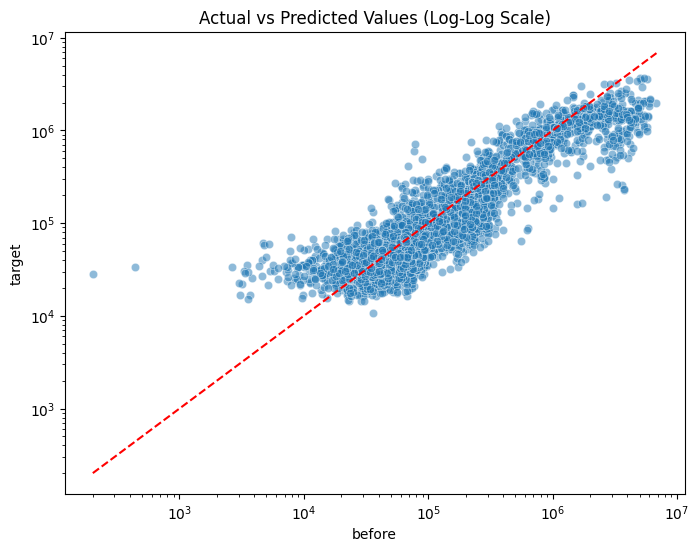

In [66]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

In [67]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'oof_predictions',
       'test_preds'],
      dtype='object')


In [68]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04,41051.438094
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04,60747.374179
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04,99849.734375
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04,52133.929296
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04,49886.749664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,NaN
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,NaN
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,NaN
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,NaN


In [69]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04,41051.438094
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04,60747.374179
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04,99849.734375
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04,52133.929296
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04,49886.749664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,NaN
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,NaN
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,NaN
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,NaN


In [70]:
len(train_df), len(train_all_df), len(test_df)

(6045, 8553, 2508)

In [71]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:len(train_df)]
test_df = train_all_df[len(train_df):]

In [72]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04,41051.438094,0.254954
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04,60747.374179,-0.082978
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04,99849.734375,-0.584046
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04,52133.929296,0.163785
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04,49886.749664,-0.146218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,NaN,NaN
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,NaN,NaN
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,NaN,NaN
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,NaN,NaN


In [73]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [74]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [75]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [76]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions, final_train_predictions

In [77]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,0.254954
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.082978
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,-0.584046
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,0.163785
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.146218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,-0.047562
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,0.127122
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,0.071618
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,-0.029464


In [78]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [79]:
oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 30, train)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.250588184723852
Fold 1 RMSLE for model2 = 0.25019581187197937
Fold 1 RMSLE for model3 = 0.2509137855252112
Fold 1 RMSLE for model4 = 0.25004438014929325
Fold 1 RMSLE for ('model1', 'model2') = 0.25015649163961884
Fold 1 RMSLE for ('model1', 'model3') = 0.2506949628969936
Fold 1 RMSLE for ('model1', 'model4') = 0.2502455778024729
Fold 1 RMSLE for ('model2', 'model3') = 0.2503836663979075
Fold 1 RMSLE for ('model2', 'model4') = 0.2499553476224806
Fold 1 RMSLE for ('model3', 'model4') = 0.25041113041969704
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.25036035143283414
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.2500667925555372
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.2504289283338656
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.25020518195160063
Fold 1 RMSLE for all models ensemble = 0.25024404247166304
Fold 1 best combination: ('model2', 'model4') with RMSLE = 0.2499553476224806
---------------

Starting Fold 2

In [80]:
test_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.503991e+04,0.0
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.981288e+05,0.0
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.142984e+04,0.0
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.926387e+04,0.0
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.776136e+04,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,0.0
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,0.0
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,0.0
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,0.0


In [81]:
test_df["GHG_Direct_Emissions_14_in_metric_tons.1"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
train_df["preds"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)

In [82]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff,preds
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,0.254954,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.082978,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,-0.584046,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,0.163785,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.146218,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,-0.047562,5.798506e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,0.127122,1.017332e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,0.071618,1.330859e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,-0.029464,2.654853e+05


In [83]:
oof_predictions = pd.Series(oof_predictions, name='oof_predictions')

In [84]:

def after_act(preds):
    r = preds.copy()
    # for i in range(len(r)):
    #     if r[i] < np.expm1(10.15):
    #         r[i] = np.expm1(np.log1p(r[i])*100/102)
    return r

after_test_preds = after_act(test_df["GHG_Direct_Emissions_14_in_metric_tons.1"])
after_train_preds = after_act(train_df["preds"])

In [85]:
train_df["GHG_Direct_Emissions_14_in_metric_tons.1"] = after_train_preds
train_df.drop(["preds"], axis=1, inplace=True)
train_df.drop(["diff"], axis=1, inplace=True)



In [86]:
test_df["test_preds"] = after_test_preds
test_df.drop(["diff"], axis=1, inplace=True)
test_df.drop(["GHG_Direct_Emissions_14_in_metric_tons.1"], axis=1, inplace=True)
test_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,test_preds
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.503991e+04,4.506929e+04
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.981288e+05,2.975597e+05
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.142984e+04,4.115429e+04
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.926387e+04,2.836366e+04
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.776136e+04,4.837460e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,5.276594e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,1.019951e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,1.389812e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,2.627149e+05


In [87]:
train_df.to_csv("train_all_df_060.csv", index=False)
test_df.to_csv("test_all_df_060.csv", index=False)

In [88]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,5.798506e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,1.017332e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,1.330859e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,2.654853e+05


In [89]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('train_all_df_060.csv')

# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('test_all_df_060.csv')

In [90]:
len(train_df), len(test_df)

(6045, 2508)

In [91]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,5.798506e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,1.017332e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,1.330859e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,2.654853e+05


In [92]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [93]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [94]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


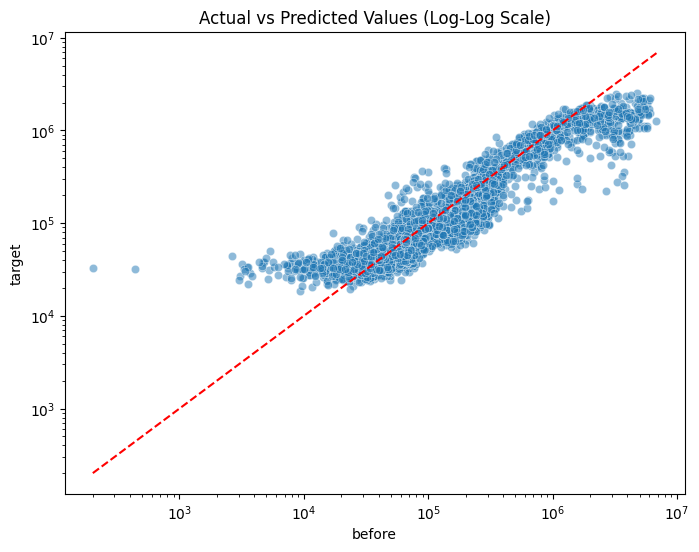

In [95]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

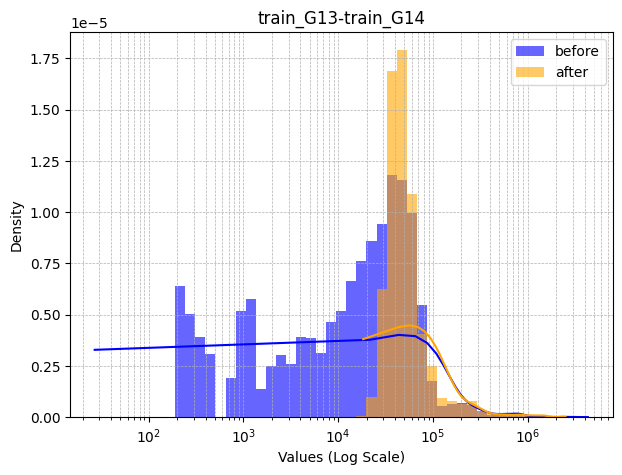

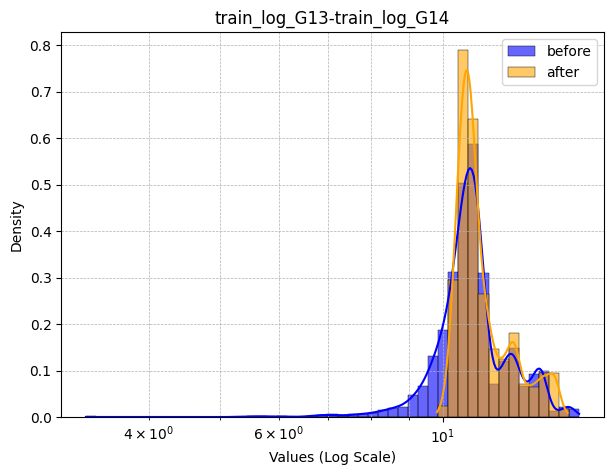

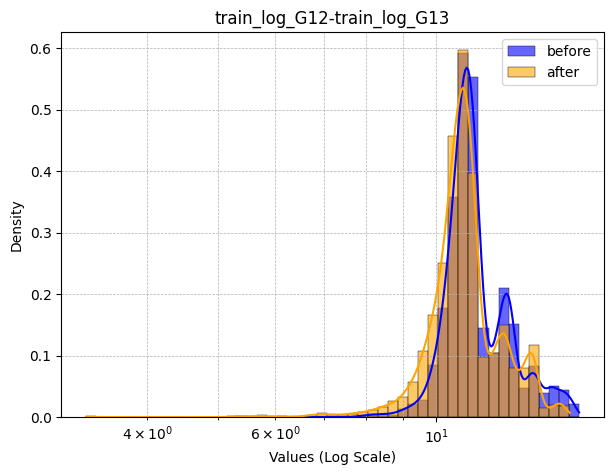

In [96]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [97]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [98]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,5.276594e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,1.019951e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,1.389812e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,2.627149e+05


In [99]:
diff = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_df['oof_predictions'])

# 2. 条件を満たす行のマスクを作成
mask = diff > 1
# 3. 除外する行の数をカウント
exclude_num = mask.sum()
# 4. 条件を満たさない行だけを保持
train_df = train_df[~mask]
print(f"除外された行の数: {exclude_num}")

除外された行の数: 0


In [100]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,5.276594e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,1.019951e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,1.389812e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,2.627149e+05


In [101]:
len(train_df), len(train_all_df), len(test_df)

(6045, 8553, 2508)

In [102]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:len(train_df)]
test_df = train_all_df[-2508:]

In [103]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,4.098466e+04,-0.001628
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,6.021565e+04,-0.008791
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,1.018654e+05,0.019985
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,5.198007e+04,-0.002956
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,4.899637e+04,-0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,5.276594e+05,0.005919
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,1.019951e+05,0.015370
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,1.389812e+05,0.017621
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,2.627149e+05,-0.008465


In [104]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [105]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [106]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [107]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")
    print()
    return oof_predictions, final_test_predictions, final_train_predictions

In [108]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,-0.001628
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.008791
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,0.019985
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,-0.002956
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,0.005662
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,0.015313
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,0.011971
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,-0.008572


In [109]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [110]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,-0.001628
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.008791
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,0.019985
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,-0.002956
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.245456e+05,0.005919
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.004395e+05,0.015370
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.365536e+05,0.017621
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.649483e+05,-0.008465


In [111]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.105144e+04,-0.001628
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.074737e+04,-0.008791
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9.984973e+04,0.019985
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.213393e+04,-0.002956
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.988675e+04,-0.018009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.765767e+05,0.005662
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.001873e+05,0.015313
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.315022e+05,0.011971
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.677709e+05,-0.008572


In [112]:
train_df_GHG14 = pd.Series(train_df_GHG14)

In [113]:
import time
epock = 10
for i in range(epock):
    st = time.time()
    train = train_df.iloc[:, :-1].values
    train_all = train_all_df.iloc[:, :-1].values
    train_all_target = train_all_df.iloc[:, -1].values
    oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 30, train)
    train_all_df["oof_predictions"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)
    train_df["oof_predictions"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)
    test_df["oof_predictions"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
    # train_all_df のインデックスをリセット
    train_all_df = train_all_df.reset_index(drop=True)

# train_df_GHG14 のインデックスをリセット
    train_df_GHG14 = train_df_GHG14.reset_index(drop=True)
    train_all_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_all_df['oof_predictions'])
    train_all_df.fillna(0, inplace=True)
    train_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_df['oof_predictions'])
    print(f"{i}番目の学習が終わりました。\n")
    print(f"推定時間は{int(((epock-1-i)*(time.time()-st))/60)}\n")

ストリーミング出力は最後の 5000 行に切り捨てられました。
Fold 18 RMSLE for ('model1', 'model2') = 0.006054335837674453
Fold 18 RMSLE for ('model1', 'model3') = 0.0061657413732862515
Fold 18 RMSLE for ('model1', 'model4') = 0.0061537058631853
Fold 18 RMSLE for ('model2', 'model3') = 0.006089062140853278
Fold 18 RMSLE for ('model2', 'model4') = 0.006110415602863163
Fold 18 RMSLE for ('model3', 'model4') = 0.006204610849738166
Fold 18 RMSLE for ('model1', 'model2', 'model3') = 0.006089843662909632
Fold 18 RMSLE for ('model1', 'model2', 'model4') = 0.006098012537517986
Fold 18 RMSLE for ('model1', 'model3', 'model4') = 0.006169064500958418
Fold 18 RMSLE for ('model2', 'model3', 'model4') = 0.006121696477114743
Fold 18 RMSLE for all models ensemble = 0.0061146657758990725
Fold 18 best combination: ('model1', 'model2') with RMSLE = 0.006054335837674453
---------------

Starting Fold 19
Fold 19 RMSLE for model1 = 0.007896977892536267
Fold 19 RMSLE for model2 = 0.007602314340524389
Fold 19 RMSLE for model3 = 0.0081326

In [114]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,40851.426566,0.003256
1,0.000000,0.000000,0.000000,0.000000,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14,1,60411.189006,-0.003242
2,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.000000,0.000000e+00,0.000000,39.299820,-80.857170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,1,101867.447903,-0.000020
3,0.000000,0.000000,0.000000,0.000000,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,1,51911.161755,0.001327
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,49141.155975,-0.002951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8548,0.000000,0.000000,0.000000,0.000000,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0.000000,0.000000
8549,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.000000,0.000000e+00,0.000000,31.361795,-101.776403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,1,0.000000,0.000000
8550,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,0.000000,0.000000
8551,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,0.000000,0.000000


In [115]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,4.085143e+04,0.003256
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.041119e+04,-0.003242
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.018674e+05,-0.000020
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.191116e+04,0.001327
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.914116e+04,-0.002951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.825716e+05,-0.004682
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.018818e+05,-0.001460
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.325146e+05,0.004302
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.660856e+05,-0.002259


In [116]:
oof_predictions = pd.Series(oof_predictions, name='oof_predictions')


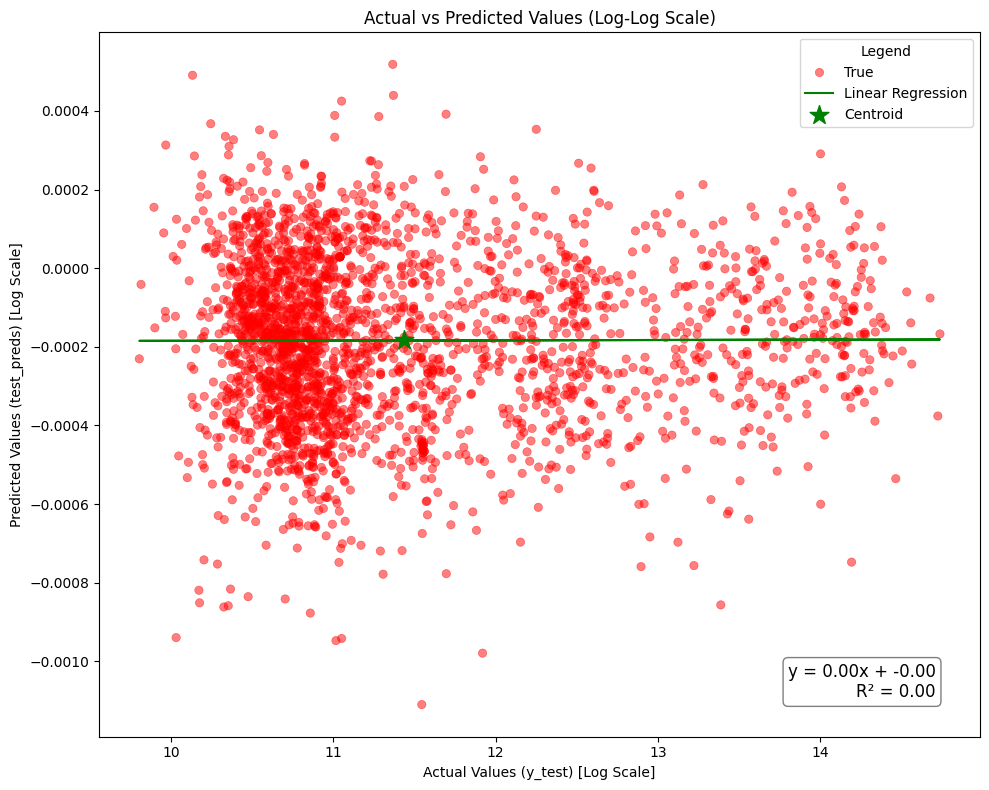

重心 (Centroid) の座標: (11.43, -0.00)


In [117]:
from scipy import stats
# 対数変換
log_target = np.log1p(test_df["oof_predictions"])
log_oof_predictions = test_preds

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [118]:
train_df_GHG14

,GHG_Direct_Emissions_14_in_metric_tons.1
0,4.098466e+04
1,6.021565e+04
2,1.018654e+05
3,5.198007e+04
4,4.899637e+04
...,...
6040,5.798506e+05
6041,1.017332e+05
6042,1.330859e+05
6043,2.654853e+05


In [119]:
test_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.518918e+04,0.000652
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.961222e+05,-0.001911
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.079498e+04,-0.006673
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.736852e+04,-0.031244
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.911759e+04,0.012758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.328587e+05,0.005919
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.039791e+05,0.015370
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412309e+05,0.017621
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.611853e+05,-0.008465


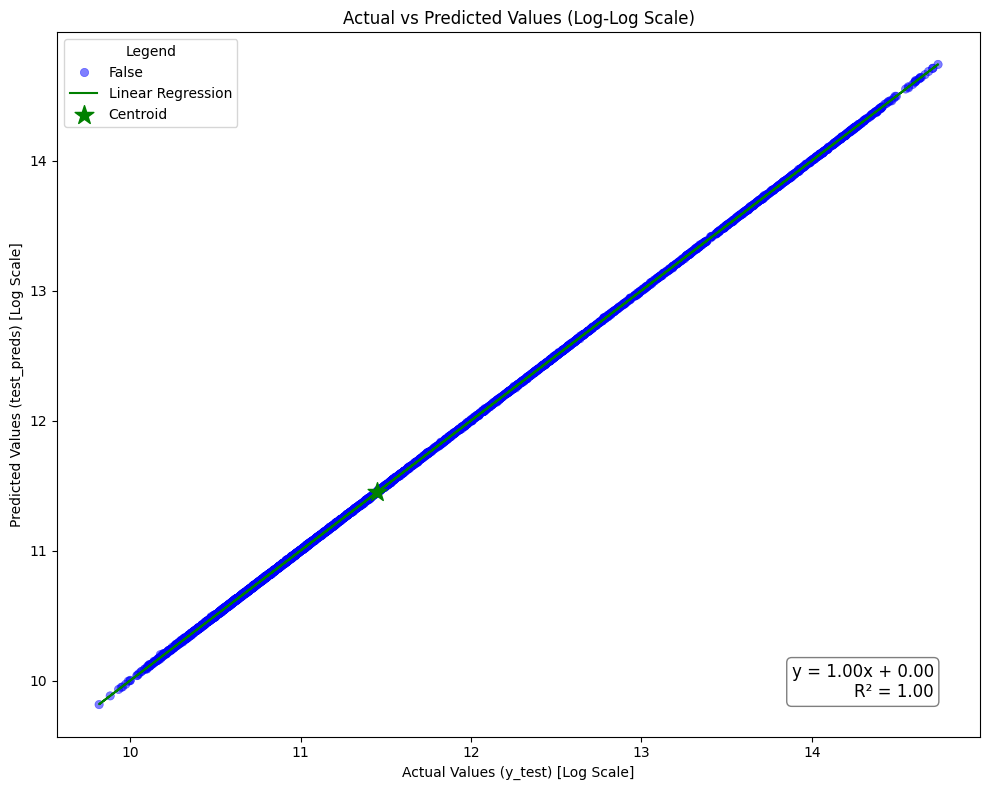

重心 (Centroid) の座標: (11.45, 11.45)


In [120]:

# 対数変換
log_target = np.log1p(train_df_GHG14)
log_oof_predictions = np.log1p(train_df["oof_predictions"])

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [121]:
print(np.expm1(10.2))
print(np.log1p(26902.18607429754))
np.expm1(np.log1p(26902.18607429754)*100/102)

26902.18607429754
10.2


22025.465794806678

In [122]:
submit = pd.read_csv(path+'sample_submission.csv',  header = None)
submit

,0,1
0,4655,249574.303827
1,4656,249574.303827
2,4657,249574.303827
3,4658,249574.303827
4,4659,249574.303827
...,...,...
2503,7158,249574.303827
2504,7159,249574.303827
2505,7160,249574.303827
2506,7161,249574.303827


各ビンの y のジオメトリック平均: 215142.02959180146


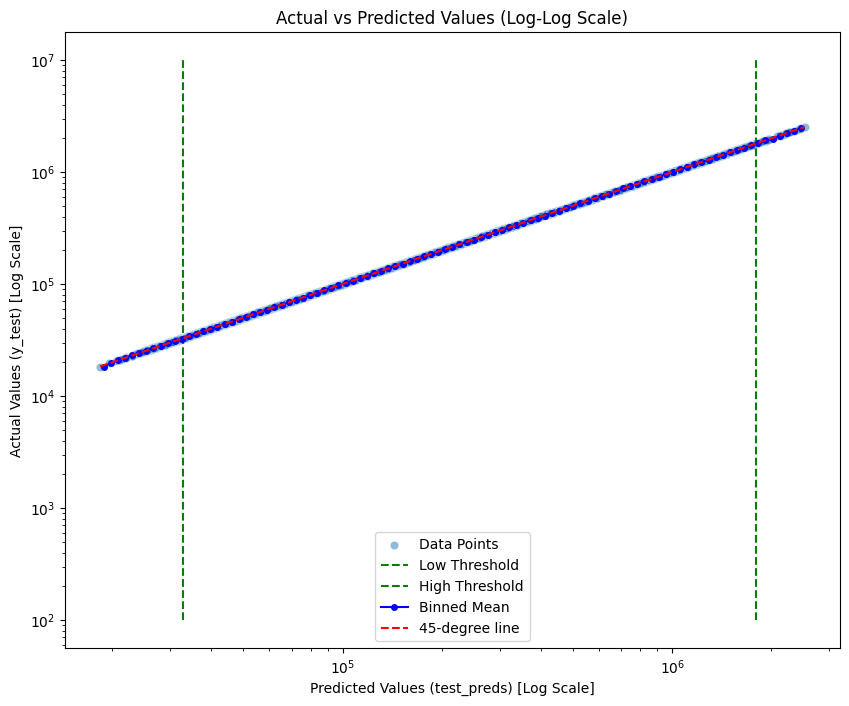

In [123]:

def calculate_binned_average(x, y, num_bins=50):
    """
    x を num_bins 個のビンに分け、それぞれのビン内の y の平均を計算します。

    Parameters:
    - x: 予測値の配列
    - y: 実測値の配列
    - num_bins: ビンの数

    Returns:
    - bins: ビンの境界
    - bin_centers: 各ビンの中心値
    - y_means: 各ビン内の y の平均値
    """
    # 対数スケールのビンを作成
    log_min = np.log10(x.min())
    log_max = np.log10(x.max())
    bins = np.logspace(log_min, log_max, num=num_bins)

    # ビンのインデックスを取得
    bin_indices = np.digitize(x, bins)

    # 各ビン内の y の平均を計算
    y_means = []
    bin_centers = []
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            y_mean = y[mask].mean()
            y_means.append(y_mean)
            bin_center = (bins[i-1] + bins[i]) / 2
            bin_centers.append(bin_center)

    return bins, np.array(bin_centers), np.array(y_means)


x = train_df_GHG14
y = train_df["oof_predictions"]
# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')


# 基準点の垂直線のプロット
plt.plot([np.expm1(10.4), np.expm1(10.4)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.4), np.expm1(14.4)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [124]:
print(np.expm1(np.log1p(10)))

10.000000000000002


In [125]:
test_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,4.518918e+04,0.000652
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.961222e+05,-0.001911
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,4.079498e+04,-0.006673
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,2.736852e+04,-0.031244
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,4.911759e+04,0.012758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.328587e+05,0.005919
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.039791e+05,0.015370
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412309e+05,0.017621
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.611853e+05,-0.008465


In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def after_act(preds):
    r = preds.copy()
    r_min = r.min()
    max_w = 10.4-np.log1p(r_min)
    for i in range(len(r)):
        if r[i] < np.expm1(10.4):
            # print(r[i]-np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w))
            r[i] = np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w)
    return r

after_test_preds = after_act(test_df["oof_predictions"])
after_train_preds = after_act(train_df["oof_predictions"])

各ビンの y のジオメトリック平均: 179757.12076097145


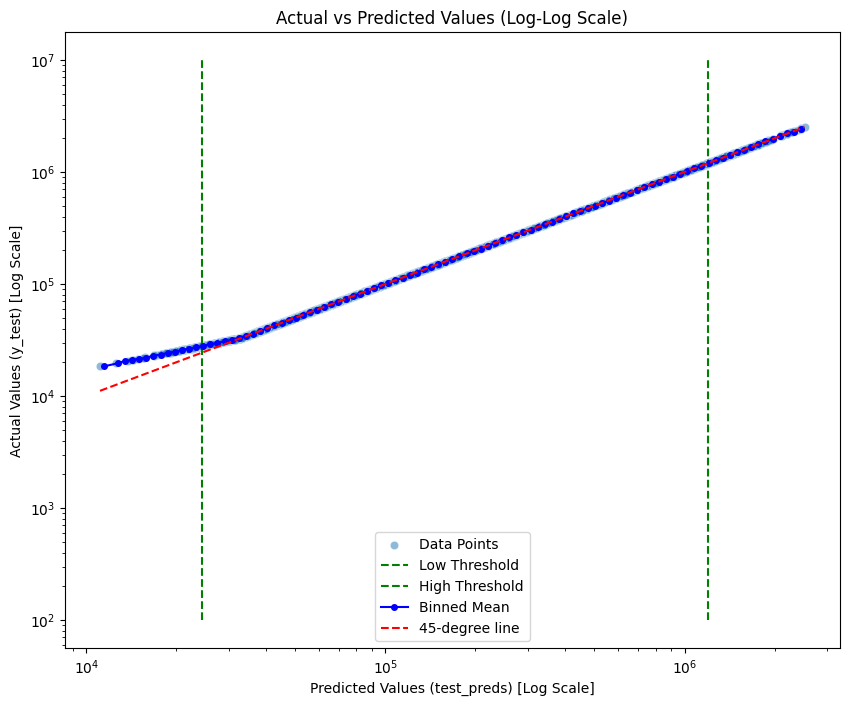

In [127]:
x = after_train_preds
y = train_df_GHG14

# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 45度線のプロット
# plt.plot([train_target.min(), train_target.max()], [train_target.min(), train_target.max()], 'r--', label='45-degree line')

# 基準点の垂直線のプロット
plt.plot([np.expm1(10.1), np.expm1(10.1)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.0), np.expm1(14.0)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [128]:
submit [ 1 ]  =  after_test_preds
submit.to_csv('SMBC_097.csv', index = False)
submit

,0,1
0,4655,4.518918e+04
1,4656,2.961222e+05
2,4657,4.079498e+04
3,4658,2.347859e+04
4,4659,4.911759e+04
...,...,...
2503,7158,5.328587e+05
2504,7159,1.039791e+05
2505,7160,1.412309e+05
2506,7161,2.611853e+05


In [129]:
submit

,0,1
0,4655,4.518918e+04
1,4656,2.961222e+05
2,4657,4.079498e+04
3,4658,2.347859e+04
4,4659,4.911759e+04
...,...,...
2503,7158,5.328587e+05
2504,7159,1.039791e+05
2505,7160,1.412309e+05
2506,7161,2.611853e+05


In [130]:
np.expm1(14)

1202603.2841647768

In [131]:
pd.set_option('display.float_format', '{:,.0f}'.format)
threshold_input = 14
threshold = np.expm1(threshold_input)/1.05  # ≈ 1.718

# フィルタリング条件を定義
condition = (submit.iloc[:, 1] > threshold) & (submit.iloc[:, 0] > 1)

# 条件に合致する行を抽出
filtered_submit = submit[condition]
filtered_submit

,0,1
16,4671,"1,174,817"
110,4765,"1,426,934"
114,4769,"1,255,593"
148,4803,"1,767,671"
178,4833,"1,550,517"
...,...,...
2417,7072,"1,242,035"
2423,7078,"1,236,865"
2466,7121,"1,580,927"
2490,7145,"1,404,446"


In [132]:

# # show_plot(np.exp(oof_predictions), np.exp(target))
# show_plot(oof_predictions, target, "oof_predictions, target")
# show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
#           "train_df[GHG_Direct_Emissions_13_in_metric_tons], np.log(train_df[GHG_Direct_Emissions_14_in_metric_tons.1])")
# show_plot(np.log(test_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(after_test_preds),
#           "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")
# show_plot(np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]), np.log(after_test_preds),
#           "train_df[GHG_Direct_Emissions_14_in_metric_tons], test_preds")
# show_plot(train_df.iloc[:, -1], after_train_preds, "train_df.iloc[:, -1], train_preds")

In [133]:
# show_plot(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"], test_preds, "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")

In [134]:
import time
print(time.ctime())

Tue Dec  3 08:02:46 2024


In [135]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"31,567","26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"40,851",0
1,NaN,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"60,411",-0
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"101,867",-0
3,NaN,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,911",0
4,"29,554","28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"49,141",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"582,572",-0
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"101,882",-0
6042,"22,956","23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"132,515",0
6043,"124,461","140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"266,086",-0


In [136]:
train_df


,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"31,567","26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"40,851",0
1,NaN,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"60,411",-0
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"101,867",-0
3,NaN,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,911",0
4,"29,554","28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"49,141",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"582,572",-0
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"101,882",-0
6042,"22,956","23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"132,515",0
6043,"124,461","140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"266,086",-0
